# Load Data
Nous chargerons toutes les données sauf les colonnes 219 V qui ont été déterminées redondantes par analyse de corrélation

In [1]:

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [2]:
"""
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Zeta Team/'
"""

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\npath = 'gdrive/My Drive/Zeta Team/'\n"

In [3]:
X_train = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

In [4]:
%%time
"""

# LOAD TRAIN
X_train = pd.read_csv(path+'train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv(path+'train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv(path+'test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv(path+'test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

"""
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 52.7 ms, sys: 2.03 ms, total: 54.7 ms
Wall time: 55 ms


# Normaliser les colonnes D
Les colonnes D sont des "deltas temporels" d'un certain moment dans le passé. Nous transformerons les colonnes D en leur point dans le passé. Cela empêchera les colonnes D d'augmenter avec le temps. La formule est `D15n = Transaction_Day - D15` et `Transaction_Day = TransactionDT / (24 * 60 * 60)`. Ensuite, nous multiplions ce nombre par `-1`.

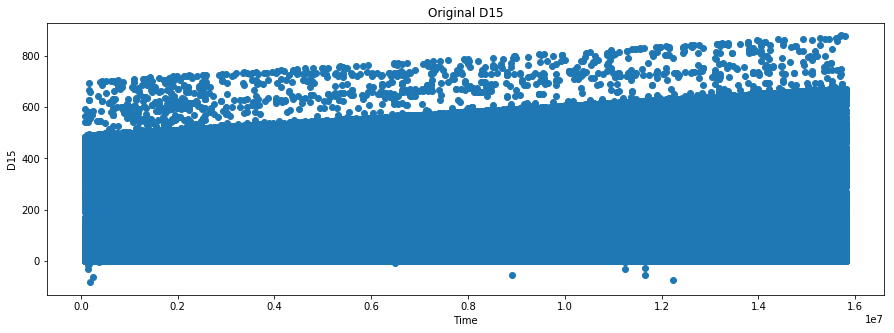

In [5]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [6]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

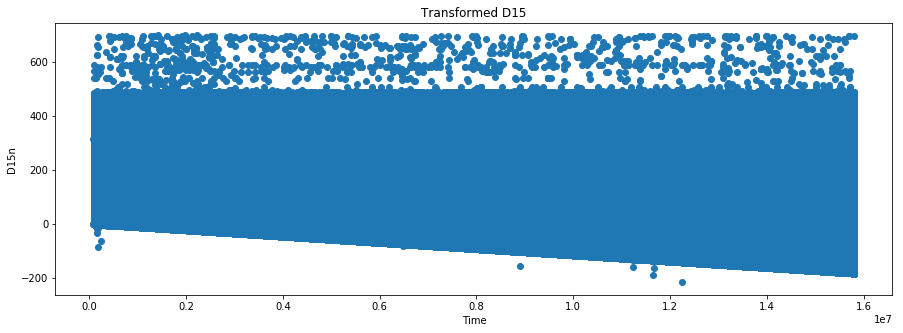

In [7]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [8]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 3.32 s, sys: 53.6 ms, total: 3.37 s
Wall time: 3.22 s


# Fonctions d'encodage
Voici 5 fonctions d'encodage : (1) `encode_FE` fait un encodage de fréquence où il combine d'abord train et test puis encode. (2) `encode_LE` est une étiquette encodée pour des features catégorielles (3)` encode_AG` crée des features agrégées telles que la moyenne agrégée et std (4) `encode_CB` combine deux colonnes (5)` encode_AG2` crée des features agrégées où il compte comment de nombreuses valeurs uniques d'une fonction se trouvent dans un groupe. Pour plus d'explications sur l'ingénierie des features, voir la discussion [ici][1]

[1]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-641841

In [9]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

# Feature Engineering
Nous allons maintenant concevoir des features. Toutes ces features ont été choisies car chacune augmente la validation locale. La procédure pour les features d'ingénierie est la suivante. On pense d'abord à une idée pour créer une nouvelle feature. Ensuite, on l'ajoute à notre modèle et on évalue si l'AUC de validation locale augmente ou diminue. Si AUC augmente, on conserve la feature, sinon on la supprimme.

In [10]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 18.6 s, sys: 6.29 s, total: 24.9 s
Wall time: 25.1 s


# Sélection des features - Cohérence temporelle
Nous avons ajouté **28 nouvelles features** ci-dessus. Nous avons déjà supprimé les colonnes 219 V de l'analyse de corrélation effectuée. Nous avons donc actuellement 242 features. Nous allons maintenant vérifier chacun de nos 242 pour la "cohérence temporelle". Nous construirons 242 modèles. Chaque modèle sera formé le premier mois des données de formation et n'utilisera qu'une seule features. Nous prédirons ensuite le dernier mois des données d'entraînement. Nous voulons que l'AUC de l'entrainnement et l'AUC de validation soient supérieures à «AUC = 0,5». Il s'avère que **19 features** échouent à ce test, nous allons donc les supprimer. De plus, nous supprimerons** 7 colonnes D **qui sont principalement **NAN**. D'autres techniques de sélection des fonctionnalités sont répertoriées [ici][2]

[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
[2]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308

In [11]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [12]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Features Importances 
Nous avons utilisé une validation locale basée sur le temps. J'ai évalué les features en m'entraînant sur les 75% des premières données et en prédisant les 25% des dernières données. Notre modèle XGB actuel avec **216** features atteint `AUC = 0,9363` sur la validation locale  
Ref : [ici][1] et [ici][2].

[1]: https://www.kaggle.com/kyakovlev/ieee-fe-for-local-test
[2]: https://www.kaggle.com/kyakovlev/ieee-lgbm-with-groupkfold-cv

In [13]:
# TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]


In [14]:
import xgboost as xgb
import lightgbm as lgb 


In [15]:
def imoortance(clf):
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)
    
    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()

## XGB variables importantes :


[0]	validation_0-auc:0.78746
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.87828
[100]	validation_0-auc:0.89504
[150]	validation_0-auc:0.90824
[200]	validation_0-auc:0.91922
[250]	validation_0-auc:0.92617
[300]	validation_0-auc:0.93047
[350]	validation_0-auc:0.93377
[400]	validation_0-auc:0.93541
[450]	validation_0-auc:0.93630
[500]	validation_0-auc:0.93667
[550]	validation_0-auc:0.93637
[600]	validation_0-auc:0.93614
Stopping. Best iteration:
[507]	validation_0-auc:0.93672



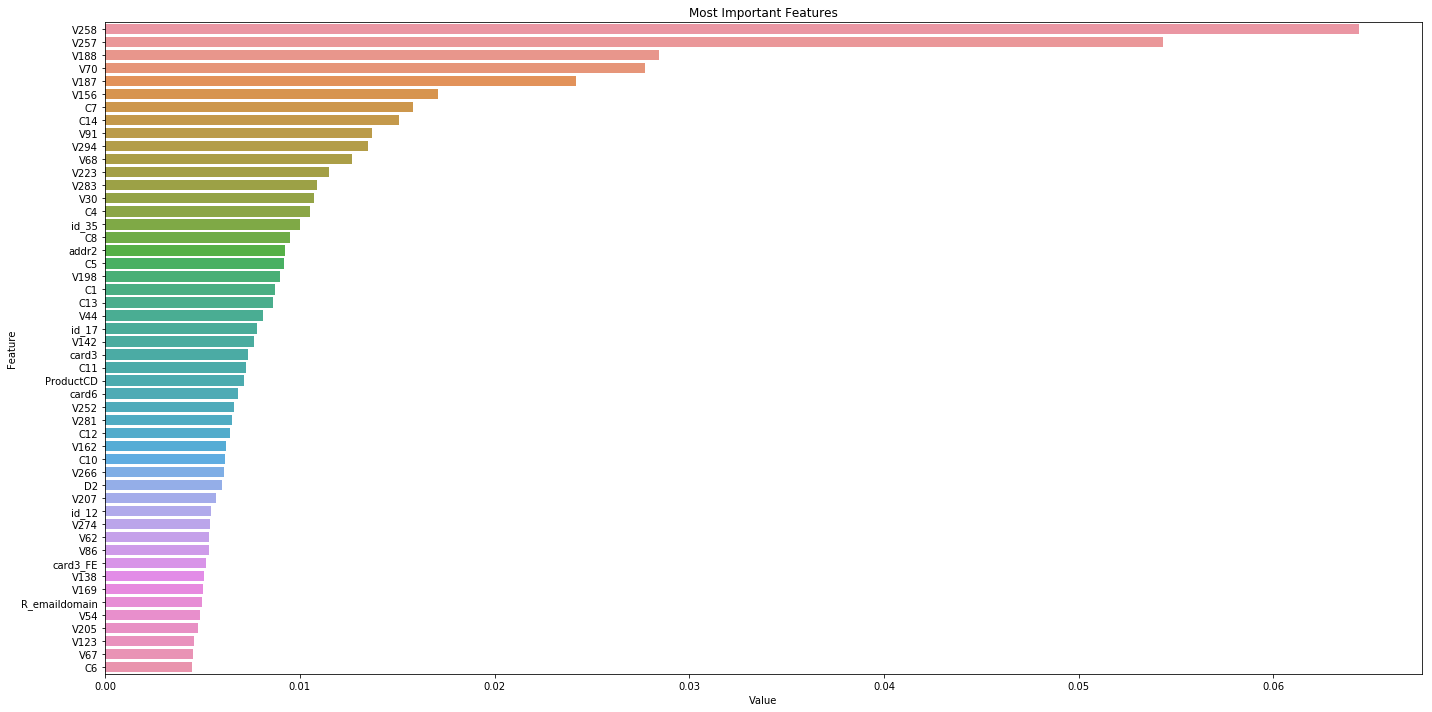

In [16]:
XGB= xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        tree_method='gpu_hist' 
    )
imoortance(XGB)

## LGBM variables importantes : 

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.866779
[100]	valid_0's auc: 0.875839
[150]	valid_0's auc: 0.888871
[200]	valid_0's auc: 0.897115
[250]	valid_0's auc: 0.903204
[300]	valid_0's auc: 0.907693
[350]	valid_0's auc: 0.910073
[400]	valid_0's auc: 0.912354
[450]	valid_0's auc: 0.914049
[500]	valid_0's auc: 0.915441
[550]	valid_0's auc: 0.916554
[600]	valid_0's auc: 0.9179
[650]	valid_0's auc: 0.919253
[700]	valid_0's auc: 0.920858
[750]	valid_0's auc: 0.921374
[800]	valid_0's auc: 0.922095
[850]	valid_0's auc: 0.923308
[900]	valid_0's auc: 0.92423
[950]	valid_0's auc: 0.924724
[1000]	valid_0's auc: 0.925475
[1050]	valid_0's auc: 0.925807
[1100]	valid_0's auc: 0.926251
[1150]	valid_0's auc: 0.926471
[1200]	valid_0's auc: 0.926837
[1250]	valid_0's auc: 0.92676
[1300]	valid_0's auc: 0.927015
[1350]	valid_0's auc: 0.927046
[1400]	valid_0's auc: 0.927058
[1450]	valid_0's auc: 0.92731
[1500]	valid_0's auc: 0.927686
[1550]	valid_0's auc: 0.928056
[1

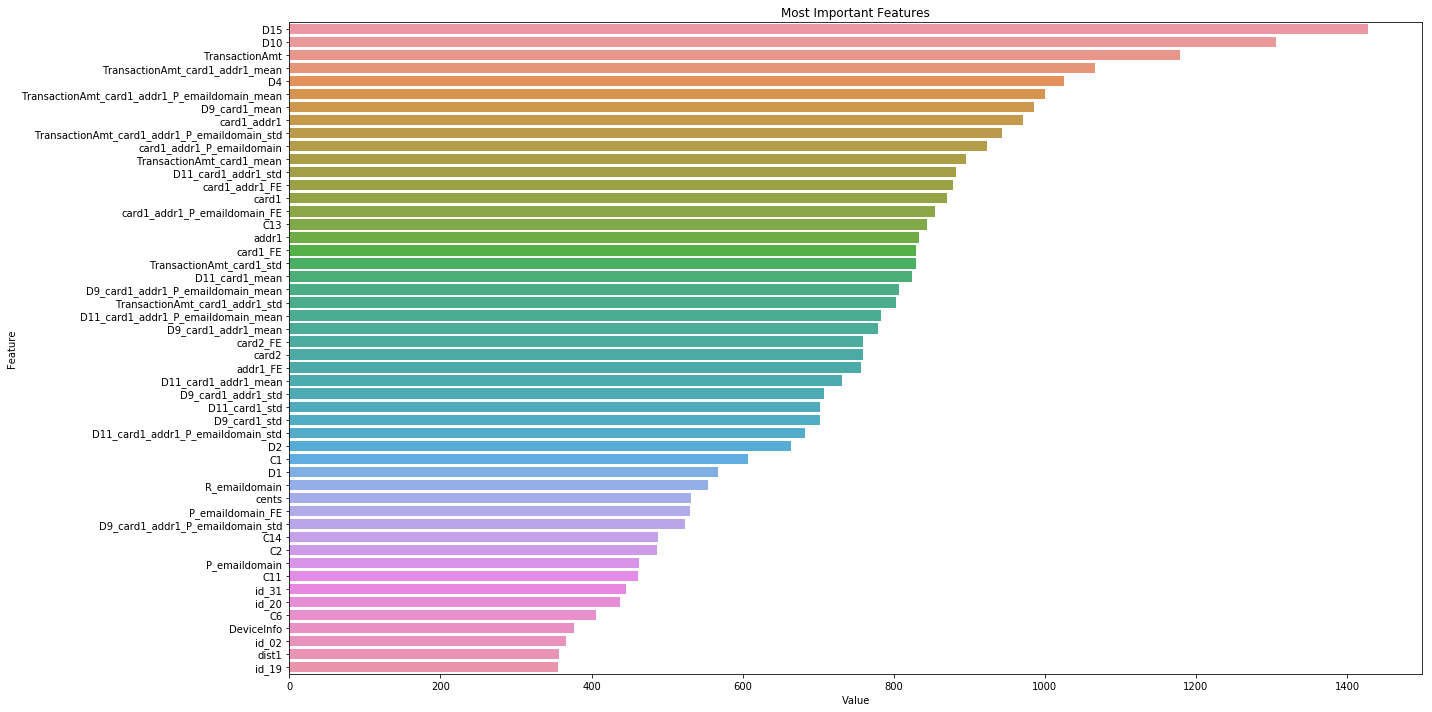

In [17]:
LGBM=lgb.LGBMClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    metric='auc',
    #nthread=4,
    #tree_method='hist' 
    device_type='gpu')
imoortance(LGBM)

# Predict test.csv

Nous prédirons `test.csv` en utilisant GroupKFold avec des mois en tant que groupes. Les données d'entrainnement** sont les mois de décembre 2017, janvier 2018, février 2018, mars 2018, avril 2018 et mai 2018. Nous appelons ces mois 12, 13, 14, 15, 16, 17. Un pli dans GroupKFold entraînera mois 13 à 17 et prédire le mois 12. Notez que le seul but du mois 12 est de dire à XGB quand "early_stop" nous ne nous soucions pas vraiment des prévisions de temps en arrière. Le modèle formé sur les mois 13 à 17 prédira également «test.csv» qui est en avance dans le temps.
  
Notez que nous utilisons la validation locale pour déterminer les fonctionnalités mais GroupKFold pour prédire `test.csv`. De nombreux autres schémas de prédiction ont été essayés mais GroupKFold a obtenu les meilleurs résultats.

In [18]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 



In [19]:
def resultats(classifier,name):
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))
    skf = GroupKFold(n_splits=5)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
          month = X_train.iloc[idxV]['DT_M'].iloc[0]
          print('Fold',i,'withholding month',month)
          print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
          clf=classifier

          h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                  eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                  verbose=100, early_stopping_rounds=200)

          oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
          preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
          del h,clf
          x=gc.collect()
        
    print('#'*20)
    print(name+'_CV=',roc_auc_score(y_train,oof))
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title(name)
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv(name+'.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)
    return preds


## XGBM

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.75719
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.87103
[200]	validation_0-auc:0.89131
[300]	validation_0-auc:0.90343
[400]	validation_0-auc:0.90745
[500]	validation_0-auc:0.90871
[600]	validation_0-auc:0.90897
[700]	validation_0-auc:0.90910
[800]	validation_0-auc:0.90912
[900]	validation_0-auc:0.90861
Stopping. Best iteration:
[757]	validation_0-auc:0.90940

Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.83223
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.90643
[200]	validation_0-auc:0.92911
[300]	validation_0-auc:0.94017
[400]	validation_0-auc:0.94407
[500]	validation_0-auc:0.94506
[600]	validation_0-auc:0.94540
[700]	validation_0-auc:0.94547
[800]	validation_0-auc:0.94526
Stopping. Best iteration:
[697]	validation_0-auc:0.94554

Fold 2 withhold

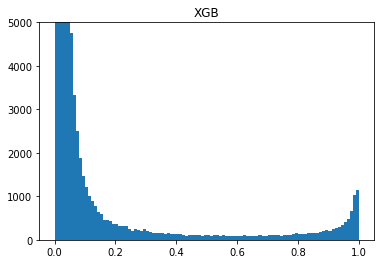

In [20]:
pred_xgb=resultats(XGB,'XGB')

## LGBM

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.859412
[200]	valid_0's auc: 0.873393
[300]	valid_0's auc: 0.885075
[400]	valid_0's auc: 0.89123
[500]	valid_0's auc: 0.896433
[600]	valid_0's auc: 0.900384
[700]	valid_0's auc: 0.90239
[800]	valid_0's auc: 0.903798
[900]	valid_0's auc: 0.905345
[1000]	valid_0's auc: 0.906355
[1100]	valid_0's auc: 0.907609
[1200]	valid_0's auc: 0.908321
[1300]	valid_0's auc: 0.909218
[1400]	valid_0's auc: 0.909133
[1500]	valid_0's auc: 0.909539
[1600]	valid_0's auc: 0.909971
[1700]	valid_0's auc: 0.910252
[1800]	valid_0's auc: 0.910416
[1900]	valid_0's auc: 0.911057
[2000]	valid_0's auc: 0.911322
Did not meet early stopping. Best iteration is:
[1989]	valid_0's auc: 0.91134
Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.889068
[200]

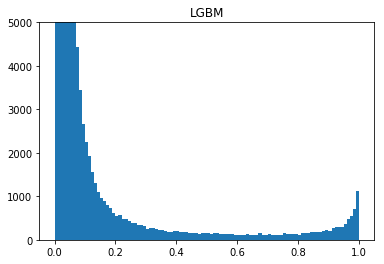

In [21]:
pred_lgbm=resultats(LGBM,'LGBM')

# Submissions

In [22]:
def submission(predictions,name):
    #### SUbmission
    sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
    sample_submission.isFraud = predictions
    sample_submission.to_csv(name+'.csv',index=False)
    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title(name+'Submission')
    plt.show()

### XGB

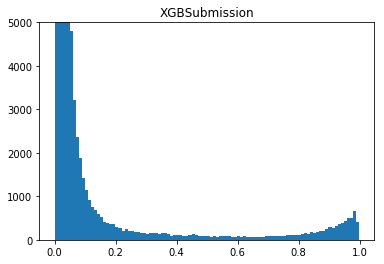

In [23]:
submission(pred_xgb,'XGB')

### LGBM

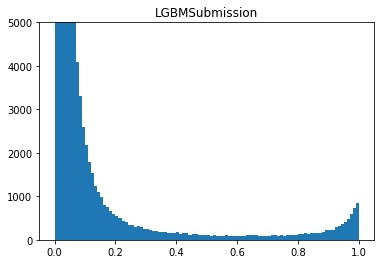

In [24]:
submission(pred_lgbm,'LGBM')

# The Magic Feature - UID
Nous allons maintenant créer et utiliser les FEATURES MAGIQUES. Nous créons d'abord un UID qui aidera notre modèle à trouver des clients (cartes de crédit). Cet UID n'est pas parfait. De nombreuses valeurs UID contiennent 2 clients ou plus à l'intérieur. Cependant, notre modèle le détectera et en ajoutant plus de divisions avec ses arbres, il divisera ces UID et trouvera les clients uniques (cartes de crédit).

In [25]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

# Group Aggregation Features
Pour que notre modèle utilise le nouvel UID, nous devons créer de nombreuses features de groupe agrégées. Nous ajouterons 47 nouvelles features ! Après agrégation, nous supprimons l'UID de notre modèle. Nous n'utilisons pas directement l'UID.

In [26]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 2min 44s, sys: 19.2 s, total: 3min 3s
Wall time: 3min 4s


In [27]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
for c in ['oof','DT_M','day','uid']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [28]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 263 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Validation locale
Nous allons maintenant effectuer une validation locale avec les nouvelles features magiques incluses.Notez que sans ces features , nous avons atteint `AUC = 0.951413
`.

In [29]:
# TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]


In [30]:

clf = xgb.XGBClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    eval_metric='auc',
    #nthread=4,
    #tree_method='hist' 
    tree_method='gpu_hist' 
)
h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
    eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.81697
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.89092
[100]	validation_0-auc:0.90736
[150]	validation_0-auc:0.92266
[200]	validation_0-auc:0.93329
[250]	validation_0-auc:0.94004
[300]	validation_0-auc:0.94382
[350]	validation_0-auc:0.94584
[400]	validation_0-auc:0.94689
[450]	validation_0-auc:0.94729
[500]	validation_0-auc:0.94759
[550]	validation_0-auc:0.94754
[600]	validation_0-auc:0.94732
Stopping. Best iteration:
[535]	validation_0-auc:0.94766



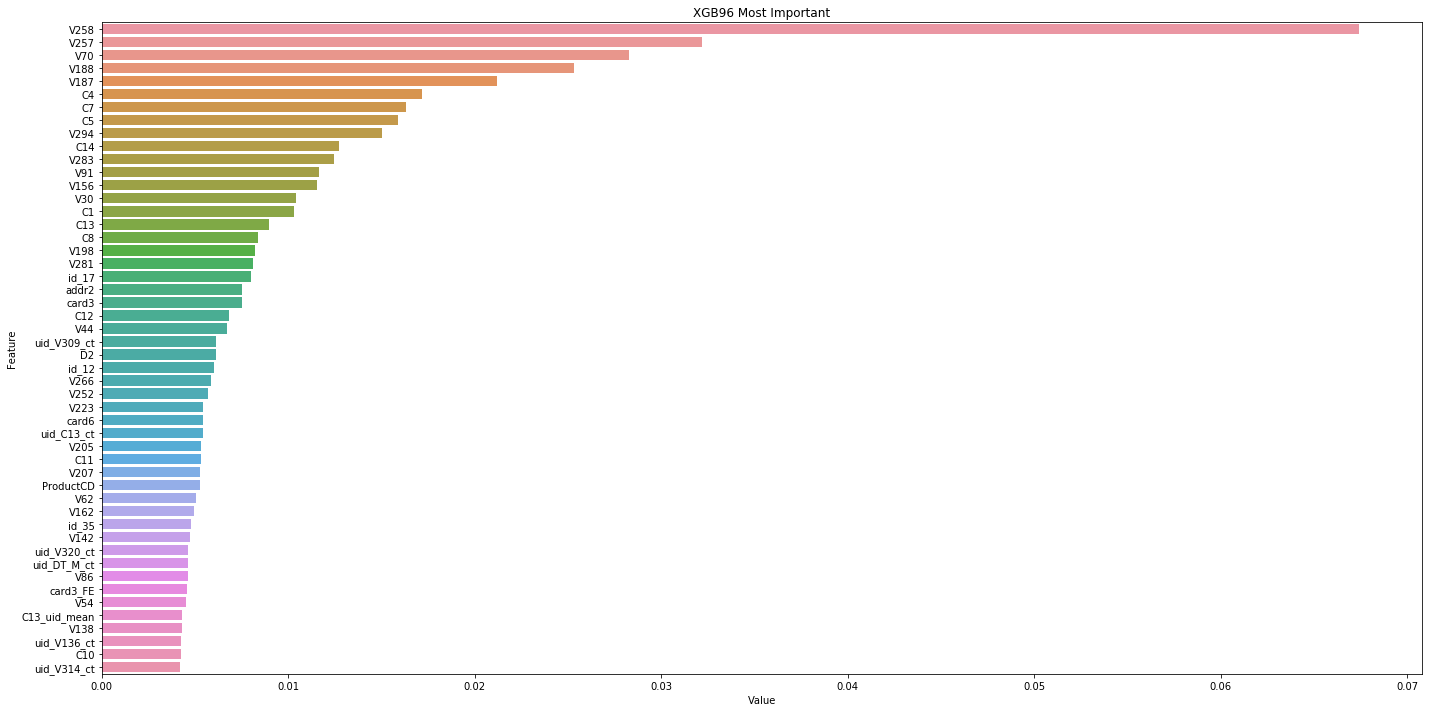

In [31]:

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB96 Most Important')
plt.tight_layout()
plt.show()
    
del clf, h; x=gc.collect()

# Predict test.csv with XGB

In [32]:

oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = xgb.XGBClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist'
        # USE GPU
        tree_method='gpu_hist' 
    )        
    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=200)

    oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
    preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
    del h, clf
    x=gc.collect()
print('#'*20)
print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.79731
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.89607
[200]	validation_0-auc:0.91415
[300]	validation_0-auc:0.92098
[400]	validation_0-auc:0.92310
[500]	validation_0-auc:0.92386
[600]	validation_0-auc:0.92482
[700]	validation_0-auc:0.92543
[800]	validation_0-auc:0.92551
[900]	validation_0-auc:0.92545
[1000]	validation_0-auc:0.92592
[1100]	validation_0-auc:0.92603
[1200]	validation_0-auc:0.92611
[1300]	validation_0-auc:0.92652
[1400]	validation_0-auc:0.92701
[1500]	validation_0-auc:0.92746
[1600]	validation_0-auc:0.92809
[1700]	validation_0-auc:0.92841
[1800]	validation_0-auc:0.92874
[1900]	validation_0-auc:0.92907
[2000]	validation_0-auc:0.92934
[2100]	validation_0-auc:0.92956
[2200]	validation_0-auc:0.92987
[2300]	validation_0-auc:0.92993
[2400]	validation_0-auc:0.92987
[2500]	validation_0-auc:0.93022
[2600]	validation_0-auc:0.93018
[2700]

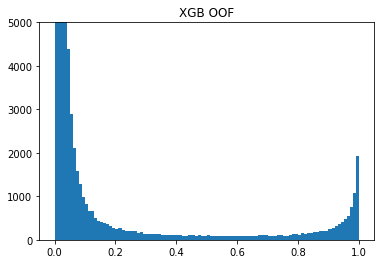

In [33]:
plt.hist(oof,bins=100)
plt.ylim((0,5000))
plt.title('XGB OOF')
plt.show()

X_train['oof'] = oof
X_train.reset_index(inplace=True)
X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
X_train.set_index('TransactionID',drop=True,inplace=True)

# Predict test.csv with LGBM

In [34]:
LGBM = lgb.LGBMClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    eval_metric='auc',
    #nthread=4,
    #tree_method='hist' 
    tree_method='gpu_hist')

In [ ]:

oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits=5)
for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = lgb.LGBMClassifier(
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist'
        # USE GPU
        tree_method='gpu_hist' 
    )        
    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=200)

    oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
    preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
    del h, clf
    x=gc.collect()
print('#'*20)
print ('LGBM OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0869929
[200]	valid_0's binary_logloss: 0.0811214
[300]	valid_0's binary_logloss: 0.0764958
[400]	valid_0's binary_logloss: 0.0739034
[500]	valid_0's binary_logloss: 0.0720678
[600]	valid_0's binary_logloss: 0.0709063
[700]	valid_0's binary_logloss: 0.0698307
[800]	valid_0's binary_logloss: 0.0689515
[900]	valid_0's binary_logloss: 0.0684807
[1000]	valid_0's binary_logloss: 0.06793
[1100]	valid_0's binary_logloss: 0.0675171
[1200]	valid_0's binary_logloss: 0.0670277
[1300]	valid_0's binary_logloss: 0.0666123
[1400]	valid_0's binary_logloss: 0.0662994
[1500]	valid_0's binary_logloss: 0.0659114
[1600]	valid_0's binary_logloss: 0.0657383
[1700]	valid_0's binary_logloss: 0.0655499
[1800]	valid_0's binary_logloss: 0.0652556
[1900]	valid_0's binary_logloss: 0.0650702
[2000]	valid_0's binary_logloss: 0.0648341
[2100]	valid

# Kaggle Submission File XGB_96

In [ ]:
sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
sample_submission.isFraud = preds
sample_submission.to_csv('sub_xgb_96.csv',index=False)

plt.hist(sample_submission.isFraud,bins=100)
plt.ylim((0,5000))
plt.title('XGB96 Submission')
plt.show()

In [ ]:
pred_proba=clf.predict_proba(X_test)[:,1]
sample_submission = pd.read_csv(path+'sample_submission.csv')
sample_submission.isFraud = pred_proba
sample_submission.to_csv('output.csv',index=False)